# Determining the age of buyers from photographs

## Project description

The Bread-Sol supermarket chain is implementing a computer vision system to process customer photos. Photo recording in the checkout area will help determine the age of customers. This is useful for business for:

- Analyze purchases and offer products that may be of interest to buyers of this age group;
- Control over the integrity of cashiers when selling alcohol.

Data taken from [ChaLearn Looking at People.](https://chalearnlap.cvc.uab.es/dataset/26/description/)

**Task:**
- Build a model that will determine the approximate age of a person from a photograph.

**Important criteria:**
- `MAE` (Mean Absolute Error) on the test sample is no more than 8.

**Work plan:**

- Loading and preparing data
- Research analysis
- Feature preparation and model training
- Summing up the work

**Description of data** - file `/faces/labels.csv`

- `file_name ` - the name of the file in which the photo is stored
- `real_age` — age of the person in the photo (***Target***)

The remaining files (with images) are stored in the `/faces/` folder

## Loading data

Importing libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

Saving a file with age data in a dataframe

In [6]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
except:
    labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
    
print(labels.shape)
labels.info()

(7591, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Load images from the directory and process them for further research

In [7]:
try:
      eda_datagen = ImageDataGenerator(rescale=1/255)
      eda_datagen_flow = eda_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345) 
except: 
      eda_datagen = ImageDataGenerator(rescale=1/255)
      eda_datagen_flow = eda_datagen.flow_from_dataframe(
            dataframe=labels,
            directory='https://code.s3.yandex.net/datasets/faces/final_files/',
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            seed=12345) 

Found 7591 validated image filenames.


The number of images in your dataset (7591) for a regression problem in the context of computer vision is quite reasonable, but it could be more, especially if it is a complex problem that requires high accuracy.

We don’t need further data preprocessing, so let’s move on to studying the images

## Exploratory data analysis

Let's look at the age distribution in the dataframe

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


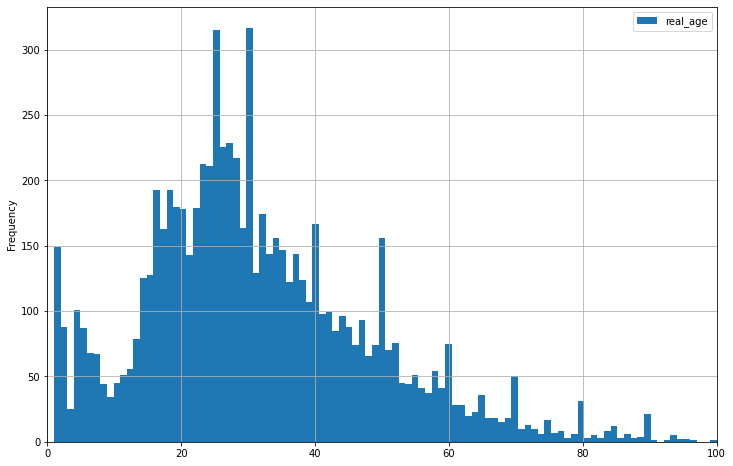

In [8]:
labels.plot(kind='hist', bins=100, figsize=(12,8), grid=True, xlim=(0,100))
labels.describe().T
plt.title('Distribution of customer ages in the dataframe')
plt.xlabel('Age')
plt.ylabel('Quantity')

- Data distribution is close to normal;
- Average age was 31 years;
- Most of the photos are in the range from 20 to 41 years old.

Let's look at 15 random photos in our dataset

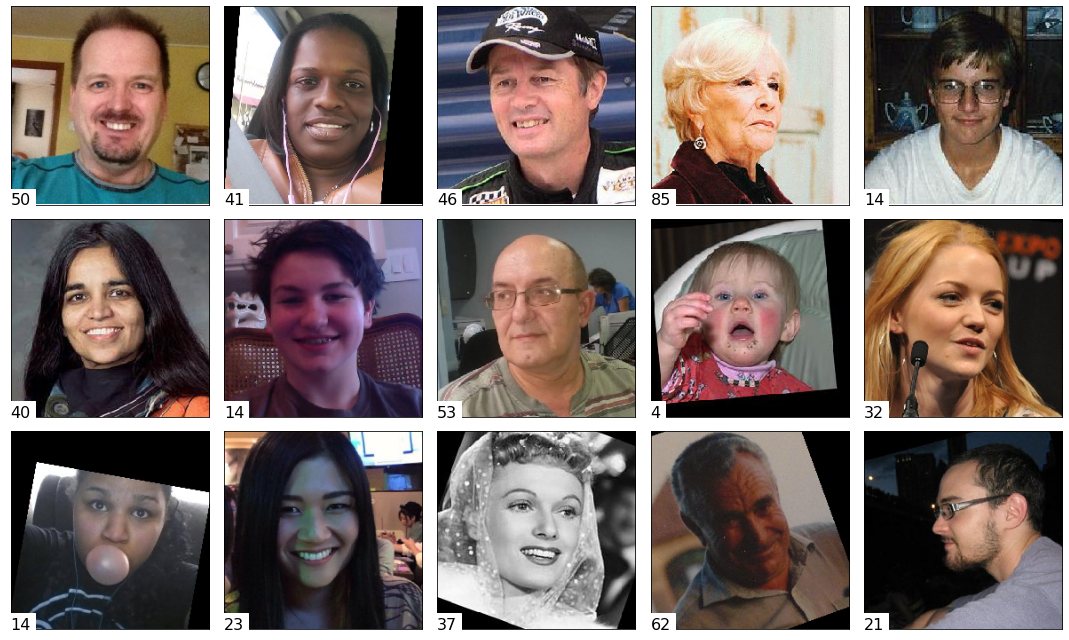

In [9]:
X_eda, y_eda = next(eda_datagen_flow)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(X_eda[i])
    plt.text(0, 0, y_eda[i], fontsize = 16, transform=ax.transAxes, backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Almost all of the images contain people's faces that match their age captions. However, there are images in the file where people's faces are not clearly depicted. The model will perform worse on such data

**EDA results:**

- The number of images in your data set is 7591. There may not be enough data for a good accuracy of the model;
- The distribution of data in the dataset is close to normal;
- The average age of the buyer is 31 years;
- Most of the photos are in the range from 20 to 41 years
- Visually the ages match the photographs;
- The data may contain a photograph where the face is not clearly visible, which may degrade its metrics.

## Model training

Since training our model requires large resources - it was trained on a GPU on a remote server, so here there will only be functions that were imported to the server and the result of their execution

Functions for preparing datasets with images

```python

# Function for preparing training data
def load_train(path):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.25,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

    img_path = path + 'final_files/'
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 


    return train_datagen_flow


# Function for preparing validation data
def load_test(path):
    test_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.25)

    img_path = path + 'final_files/'
    labels = pd.read_csv(path + 'labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=img_path,
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    
    return test_datagen_flow

```

Below is the function used to train the model. What it contains:

- 50-layer ResNet50 model with weights `resnet50_weights_tf_dim_ordering_tf_kernels_notop`;
- The last fully connected layer with one neuron and `relu` activation (since we have a regression problem);
- Loss function - `mean_squared_error`, because with it, neural networks often learn faster;
- Optimization algorithm `Adam` with `learning_rate`=0.0005.

```python

def create_model(input_shape):
    backbone  = ResNet50(input_shape=input_shape,
                 include_top=False,
                 weights='https://code.s3.yandex.net/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5') 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
               batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model


```

Output of our model:

```

Found 5694 validated image filenames.

Found 1897 validated image filenames.

<class 'keras.engine.sequential.Sequential'>

Epoch 1/20
 - 122s - loss: 205.1249 - mean_absolute_error: 10.8079 - val_loss: 567.5213 - val_mean_absolute_error: 16.1421
 
Epoch 2/20
 - 96s - loss: 130.7649 - mean_absolute_error: 8.6952 - val_loss: 243.5611 - val_mean_absolute_error: 14.3007
 
Epoch 3/20
 - 95s - loss: 108.9898 - mean_absolute_error: 7.8975 - val_loss: 317.7070 - val_mean_absolute_error: 13.3315
 
Epoch 4/20
 - 87s - loss: 93.2701 - mean_absolute_error: 7.3510 - val_loss: 248.1047 - val_mean_absolute_error: 11.0380
 
Epoch 5/20
 - 84s - loss: 88.9236 - mean_absolute_error: 7.1299 - val_loss: 149.3881 - val_mean_absolute_error: 8.1276
 
Epoch 6/20
 - 85s - loss: 79.8440 - mean_absolute_error: 6.8277 - val_loss: 151.6866 - val_mean_absolute_error: 12.1218
 
Epoch 7/20
 - 83s - loss: 73.4026 - mean_absolute_error: 6.5664 - val_loss: 128.0821 - val_mean_absolute_error: 8.9492
 
Epoch 8/20
 - 84s - loss: 65.3301 - mean_absolute_error: 6.1850 - val_loss: 198.5652 - val_mean_absolute_error: 9.2804
Epoch 9/20
 - 83s - loss: 61.2178 - mean_absolute_error: 5.9531 - val_loss: 49.7469 - val_mean_absolute_error: 7.1595
 
Epoch 10/20
 - 88s - loss: 61.0719 - mean_absolute_error: 5.9542 - val_loss: 107.5550 - val_mean_absolute_error: 8.2815
 
Epoch 11/20
 - 82s - loss: 58.1033 - mean_absolute_error: 5.8121 - val_loss: 89.1011 - val_mean_absolute_error: 7.6705
 
Epoch 12/20
 - 87s - loss: 54.1546 - mean_absolute_error: 5.6058 - val_loss: 159.6992 - val_mean_absolute_error: 7.7017
 
Epoch 13/20
 - 84s - loss: 49.2940 - mean_absolute_error: 5.3726 - val_loss: 87.1735 - val_mean_absolute_error: 7.4220
 
Epoch 14/20
 - 83s - loss: 46.1132 - mean_absolute_error: 5.2286 - val_loss: 118.2191 - val_mean_absolute_error: 7.9831
 
Epoch 15/20
 - 81s - loss: 43.4809 - mean_absolute_error: 5.0457 - val_loss: 8.7441 - val_mean_absolute_error: 7.0237
 
Epoch 16/20
 - 83s - loss: 40.0834 - mean_absolute_error: 4.8580 - val_loss: 89.6566 - val_mean_absolute_error: 7.1715
 
Epoch 17/20
 - 85s - loss: 41.5550 - mean_absolute_error: 4.9570 - val_loss: 74.6471 - val_mean_absolute_error: 7.1104
 
Epoch 18/20
 - 83s - loss: 39.2015 - mean_absolute_error: 4.8033 - val_loss: 53.1108 - val_mean_absolute_error: 7.4015
 
Epoch 19/20
 - 92s - loss: 37.3195 - mean_absolute_error: 4.7039 - val_loss: 35.3193 - val_mean_absolute_error: 7.7869
 
Epoch 20/20
 - 101s - loss: 32.8236 - mean_absolute_error: 4.4178 - val_loss: 119.5867 - val_mean_absolute_error: 6.7638
 
Test MAE: 6.7638

```

## Conclusions

**Architecture and weights used**
- `Architecture:` A 50-layer ResNet50 model was used. This architecture is well suited for computer vision tasks due to its ability to capture complex features in images.
- `Pretrained weights:` The model used pretrained weights (resnet50_weights_tf_dim_ordering_tf_kernels_notop). They help speed up the learning process and improve its quality, especially when there is limited data available.

**Training Options**
- `Batch size:` 32. This is the standard choice, providing a good balance between learning speed and memory requirements.
- `Optimizer:` Adam with learning_rate=0.0005. Adam is a popular choice for training neural networks due to its efficiency in finding optimal weights.
- `Backbone weight freeze:` Not used
- `Number of epochs:` 20. This number of epochs was sufficient for initial training, using pre-trained weights, because with it it was possible to achieve the desired metric.

**Metrics achieved**
- `MAE on test set:` 6.76, which means an average absolute error of 6.7 years. The expected metric MAE <= 8 has been achieved, which means the task has been completed.